In [1]:
from azure.identity import DefaultAzureCredential, ClientSecretCredential
from azure.storage.blob import BlobServiceClient
from azure.storage.filedatalake import DataLakeServiceClient

import os
import librosa
import io
import pyspark
import numpy as np
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq
import pyarrow.fs as pa_fs
import pyarrowfs_adlgen2 as pa_adl
import librosa


from dotenv import load_dotenv
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
# this is strictly used only in development
# load env variables
env_dir = Path('../').resolve()
load_dotenv(os.path.join(env_dir, '.env'))

True

In [3]:
# Retrieve credentials from environment variables
storage_account_name = os.environ.get("STORAGE_ACCOUNT_NAME")
storage_account_key = os.environ.get("STORAGE_ACCOUNT_KEY")

In [5]:
hertz = 16000

In [6]:
SUBJECT_NAME = "1snoke-20120412-hge"

In [7]:
DIR = f"../include/data/bronze/{SUBJECT_NAME}/"

In [8]:
WAV_DIR = os.path.join(DIR, "wav")

In [9]:
path_to_wavs = os.listdir(WAV_DIR)
path_to_wavs

['a0405.wav',
 'a0406.wav',
 'a0407.wav',
 'a0408.wav',
 'a0409.wav',
 'a0410.wav',
 'a0411.wav',
 'a0412.wav',
 'a0413.wav',
 'a0414.wav']

In [10]:
ys = []
for wav in path_to_wavs:
    y, sr = librosa.load(os.path.join(WAV_DIR, wav), sr=hertz)
    
    # top_db is set to 20 representing any signal below
    # 20 decibels will be considered silence
    y_trimmed, _ = librosa.effects.trim(y, top_db=20)

#     # append y to ys 
    ys.append(y_trimmed)

In [11]:
final = np.concatenate(ys, axis=0)
final

array([ 0.00161743, -0.00213623, -0.00314331, ..., -0.00460815,
       -0.00317383, -0.00210571], shape=(608256,), dtype=float32)

In [12]:
table = pa.table({
    "signals": pa.array(final), 
    "subjectId": pa.array(["1snoke-20120412-hge"] * final.shape[0], type=pa.string()),
    "rowId": pa.array(np.arange(final.shape[0]), type=pa.int32())
})

In [13]:
table

pyarrow.Table
signals: float
subjectId: string
rowId: int32
----
signals: [[0.0016174316,-0.0021362305,-0.0031433105,0.00030517578,-0.0024414062,...,-0.0012207031,-0.0032653809,-0.0046081543,-0.0031738281,-0.002105713]]
subjectId: [["1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge",...,"1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge","1snoke-20120412-hge"]]
rowId: [[0,1,2,3,4,...,608251,608252,608253,608254,608255]]

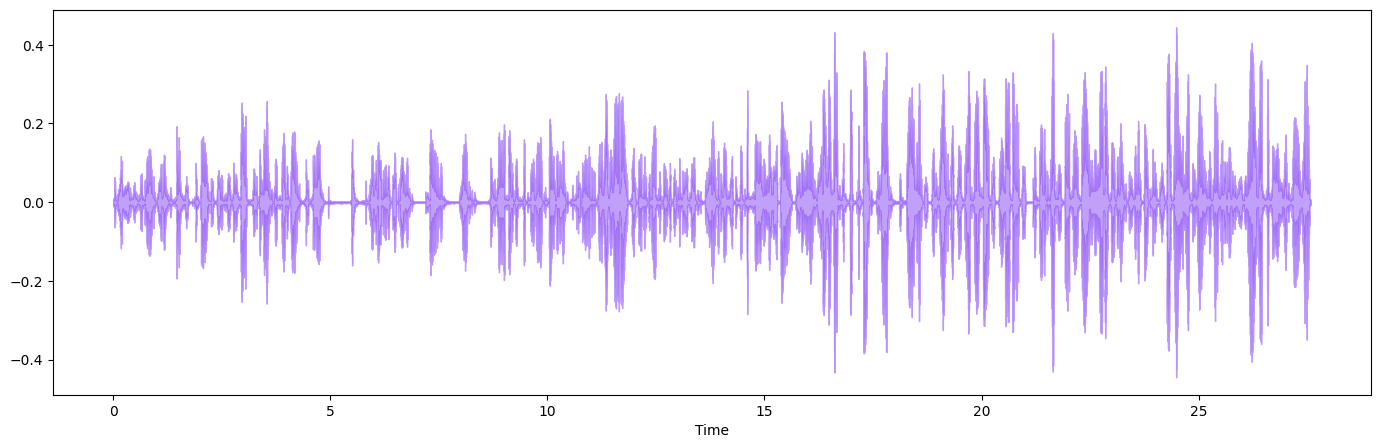

In [14]:
fig = plt.figure(figsize=(17, 5))
librosa.display.waveshow(final, alpha=0.5, color="#8442f5")
plt.show()

In [22]:
# SILVER_DATA_PATH = f"../include/data/silver/stage-01/train/{SUBJECT_NAME}_signals.parquet"
SILVER_DATA_PATH = f"{storage_account_name}-silver/stage-01/train/{SUBJECT_NAME}_signals.parquet"

# local way of saving the py arrow table to parquet

In [16]:
# pq.write_table(table, SILVER_DATA_PATH)

# cloud way of saving the py arrow table to parquet

In [17]:
# create client with generated sas token
datalake_service_client = DataLakeServiceClient(
    account_url=f"https://{storage_account_name}.dfs.core.windows.net", 
    credential=storage_account_key
)

In [18]:
handler = pa_adl.AccountHandler.from_account_name(storage_account_name, credential=storage_account_key)

In [19]:
fs = pa.fs.PyFileSystem(handler)

# write time takes approximately 1 min assuming length of signals is 600000+

In [23]:
df = pq.write_table(table, SILVER_DATA_PATH, filesystem=fs)